### Import required libraries

In [1]:
import mxnet as mx
import gluoncv as gcv
import matplotlib.pyplot as plt
import numpy as np

### Read the image

In [2]:
img = mx.image.imread('Data/alb_mount.jpg')

### Information about image

In [3]:
print("Image Type:", type(img))

Image Type: <class 'mxnet.ndarray.ndarray.NDArray'>


In [4]:
print("Image Shape:", img.shape)

Image Shape: (563, 750, 3)


In [5]:
print("Data Type:", img.dtype)

Data Type: <class 'numpy.uint8'>


In [6]:
print("Min Value: {}, and Max Value: {}".format(img.min().asscalar(), img.max().asscalar()))

Min Value: 0, and Max Value: 255


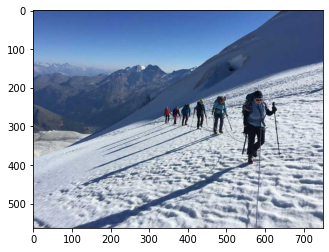

In [7]:
plt.imshow(img.asnumpy())

### Image Preprocessing

- To make a prediction, we need to preprocess our image as follow:
  1. make it's dimension from (HWC) to (NCHW)
     - N --> Batch dimension
     - C --> Channels
     - H --> Height
     - W --> Width
  2. Convert it's values from uint8 to floeat32   
  3. Normalize it's values ro range from 0:1 instead of 0:255   

In [8]:
img_transformed = gcv.data.transforms.presets.imagenet.transform_eval(img)

In [9]:
print("Shape:", img_transformed.shape)
print("Type:", img.dtype)
print("Min Value:", img_transformed.min().asscalar())
print("Max Value:", img_transformed.max().asscalar())    

Shape: (1, 3, 224, 224)
Type: <class 'numpy.uint8'>
Min Value: -2.117904
Max Value: 2.64


In [10]:
img_transformed = img_transformed.astype(np.float32)

In [11]:
# image is in NCHW format
print("Shape:", img_transformed.shape)
print("Type:", img_transformed.dtype)
print("Min Value:", img_transformed.min().asscalar())
print("Max Value:", img_transformed.max().asscalar())    

Shape: (1, 3, 224, 224)
Type: <class 'numpy.float32'>
Min Value: -2.117904
Max Value: 2.64


### Load our model ResNet50_v1d

In [12]:
model = gcv.model_zoo.get_model("ResNet50_v1d", pretrained = True)

### make prediction on image

In [13]:
prediction = model(img_transformed)

In [14]:
# prediction input is batch of images (1)
# prediction output is batch of predictions (1000)
print(prediction.shape)

(1, 1000)


In [15]:
prediction = prediction[0]

In [16]:
print(prediction.shape)

(1000,)


In [17]:
print("Skipping 950 values ...")
print(prediction[950:])

Skipping 950 values ...

[ 1.28591633e+00  5.49098134e-01  8.25667858e-01  6.13396764e-01
  9.90169585e-01  2.47432411e-01  5.32758713e-01  6.65047109e-01
 -2.82880902e-01  7.47646749e-01  2.91407526e-01  6.54395223e-01
  4.73161578e-01  5.70389330e-01  4.26879108e-01  7.00865149e-01
  9.58279371e-01  3.71057838e-01 -9.80105996e-03  3.74099553e-01
  7.54258442e+00  4.77621377e-01  1.19525754e+00  5.75736523e-01
  1.13639307e+00  1.25235701e+00  1.59557903e+00  5.51850080e-01
  1.27360439e+00  3.00583720e+00  2.59487104e+00 -8.83819461e-01
 -4.99364614e-01 -9.87131834e-01 -8.14989090e-01  8.92493725e-01
  7.11652815e-01 -1.88284695e-01  9.22471762e-01  7.21878558e-03
  5.30613422e-01  5.02888799e-01 -6.98616207e-02  4.30742919e-01
  8.10773075e-01  1.17115244e-01  4.25742865e-01  3.89085174e-01
  6.14673138e-01  4.81225908e-01]
<NDArray 50 @cpu(0)>


### Calculate probability

In [18]:
probability = mx.nd.softmax(prediction)

In [19]:
rounded_probability = mx.nd.round(probability * 100) / 100
print("Skipping 950 values ...")
print(rounded_probability[950:])

Skipping 950 values ...

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.38 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]
<NDArray 50 @cpu(0)>


### Softmax
  
   - logits ∈ [-∞ , +∞]
   - Softamx(logits) ∈ [0 , 1] and ∑Softamx(logits) = 1

#### Logits and Softmax

In [20]:
mx.nd.softmax(mx.nd.array((-0.5,0.5)))


[0.26894143 0.73105854]
<NDArray 2 @cpu(0)>

In [21]:
mx.nd.softmax(mx.nd.array((-0.5,1.0)))


[0.18242551 0.81757456]
<NDArray 2 @cpu(0)>

In [22]:
mx.nd.softmax(mx.nd.array((-1.0,1.0)))


[0.11920292 0.8807971 ]
<NDArray 2 @cpu(0)>

### Get Top K

In [23]:
k = 10
topk_indicies = mx.nd.topk(probability, k= k)
topk_indicies


[970. 795. 537. 979. 796. 980. 336. 672. 802. 203.]
<NDArray 10 @cpu(0)>

### Get Class label

In [24]:
model.classes[550]

'espresso maker'

### Final Predictions

#1 alp (38.0%)
#2 ski (29.7%)
#3 dogsled (1.19%)
#4 valley (0.407%)
#5 ski mask (0.312%)
#6 volcano (0.27%)
#7 marmot (0.26%)
#8 mountain tent (0.23%)
#9 snowmobile (0.214%)
#10 West Highland white terrier (0.159%)


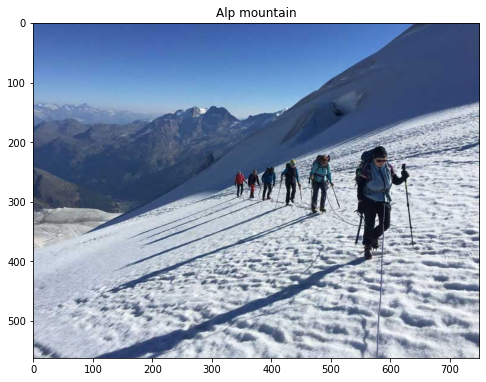

In [29]:
f, (ax1) = plt.subplots(1, 1, figsize=(8,8))
ax1.set_title('Alp mountain')
ax1.imshow(img.asnumpy())

for i in range(k):
    # convert from mxnet float to python integer
    # asscalar --> convert MXNet ND array with one lelment to python literal
    class_index = topk_indicies[i].astype('int').asscalar()
    class_label = model.classes[class_index]
    class_probability = probability[class_index]
    print('#{} {} ({:0.3}%)'.format(i+1, class_label, class_probability.asscalar()*100))